In [1]:
from data import get_cell_dataloaders
import torch
from torch.utils.data import random_split, ConcatDataset
import segmentation_models_pytorch as smp
import numpy as np
import os
from train import train_model
from loss_functions import BCE_Dice_Loss
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import skimage
import cv2

In [2]:
FOLD_DIR = "/media/u1910100/Extreme SSD/data/tiger/cell_detection/dilation/patches/128"

test_fold = 1
print(f"Testing using fold {test_fold}")
train_loader, test_loader = get_cell_dataloaders(
    FOLD_DIR, fold_num=test_fold, batch_size=1, phase="Test"
)

print(len(test_loader.sampler))

Testing using fold 1
Train files: 17904
Test files: 2792
2792


In [3]:
def imagenet_denormalise(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_normal = (img * std) + mean
    return img_normal

In [4]:
model = smp.Unet(
    encoder_name="efficientnet-b0",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
)

model.load_state_dict(
    torch.load("/home/u1910100/GitHub/TIAger-Torch/runs/cell/weights/cell_1.pth")
)

model.to("cuda")
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [ ]:
thresholds = [0.3, 0.5, 0.75, 0.99]

for threshold in thresholds:
    sum_IOU = []
    sum_F1 = []
    sum_precison = []
    sum_recall = []
    print(f"threshold = {threshold}")
    for batch in tqdm(test_loader):
        # batch = next(iter(validation_loader))
        imgs, masks = batch["img"], batch["mask"]

        img = batch["img"][0].numpy(force=True)
        img = np.moveaxis(img, 0, 2)
        img_normal = imagenet_denormalise(img)

        # rgb_mask = mask_to_rgb(masks[0][0])

        # fig, axs = plt.subplots(1, 3, figsize=(10, 10))
        # axs[0].imshow(img_nromal)
        # axs[0].title.set_text("Image")

        # axs[1].imshow(masks[0][0], cmap='gray')
        # axs[1].title.set_text("Ground Truth")

        imgs = imgs.to("cuda").float()
        masks = masks.to("cuda").long()
        with torch.no_grad():
            out = model(imgs)
            out = torch.sigmoid(out)

        tp, fp, fn, tn = smp.metrics.get_stats(
            out, masks, mode="binary", threshold=threshold
        )
        iou_score = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro", zero_division=0
        )
        f1_score = smp.metrics.f1_score(
            tp, fp, fn, tn, reduction="micro", zero_division=0
        )
        precison_score = smp.metrics.precision(
            tp, fp, fn, tn, reduction="micro", zero_division=0
        )
        recall_score = smp.metrics.recall(
            tp, fp, fn, tn, reduction="micro", zero_division=0
        )

        iou_score = iou_score.cpu().detach().item()
        f1_score = f1_score.cpu().detach().item()
        precison_score = precison_score.cpu().detach().item()
        recall_score = recall_score.cpu().detach().item()

        if math.isnan(iou_score):
            iou_score = 1
        if math.isnan(f1_score):
            f1_score = 1
        if math.isnan(precison_score):
            precison_score = 1
        if math.isnan(recall_score):
            recall_score = 1

        # out = out.cpu().detach()
        # out_mask = out[0]

        # axs[2].imshow(out_mask[0], cmap="plasma")
        # axs[2].title.set_text("Prediction")

        # for ax in fig.axes:
        #     ax.axis("off")
        # plt.show()

        # print(f"IOU (Jaccard): {iou_score}")
        # print(f"F1 (Dice): {f1_score}")

        sum_IOU.append(iou_score)
        sum_F1.append(f1_score)
        sum_precison.append(precison_score)
        sum_recall.append(recall_score)

    # sum_IOU = np.array(sum_IOU)
    # sum_F1 = np.array(sum_F1)
    print("-------------")
    print("Avg Jaccard ", np.mean(sum_IOU))
    print("Avg Dice ", np.mean(sum_F1))
    print("Avg Precision ", np.mean(sum_precison))
    print("Avg Recall ", np.mean(sum_recall))

In [5]:
def get_cell_centers(cell_mask):
    mask_label = skimage.measure.label(cell_mask)
    stats = skimage.measure.regionprops(mask_label)
    centers = []
    for region in stats:
        centroid = region["centroid"]
        centers.append(centroid)
    return centers


def point_to_box(x, y, size):
    """Convert centerpoint to bounding box of fixed size"""
    return np.array([x - size, y - size, x + size, y + size])


def check_point_in_box(x, y, box):
    cond_1 = x >= box[0] and x <= box[2]
    cond_2 = y >= box[1] and y <= box[3]
    return cond_1 and cond_2


def evaluate_cell_predictions(gt_centers, pred_centers):
    tp_x_coords = []
    tp_y_coords = []

    print(f"Total gt cells: {len(gt_centers)}")
    print(f"Total pred cells: {len(pred_centers)}")
    tp = 0
    fp = 0
    fn = 0

    for i, true_center in enumerate(gt_centers):
        true_box = point_to_box(true_center[0], true_center[1], 8)

        for j, pred_center in enumerate(pred_centers):
            if check_point_in_box(pred_center[0], pred_center[1], true_box):
                tp_x_coords.append(pred_center[0])
                tp_y_coords.append(pred_center[1])
                tp += 1
                del gt_centers[i]
                del pred_centers[j]

    fn = len(gt_centers)
    fp = len(pred_centers)

    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")

    return tp_x_coords, tp_y_coords


def erode_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.erode(mask, kernel, iterations=1)
    return mask

threshold = -6
-5.1074867
Total gt cells: 0
Total pred cells: 0
True Positives: 0
False Positives: 0
False Negatives: 0


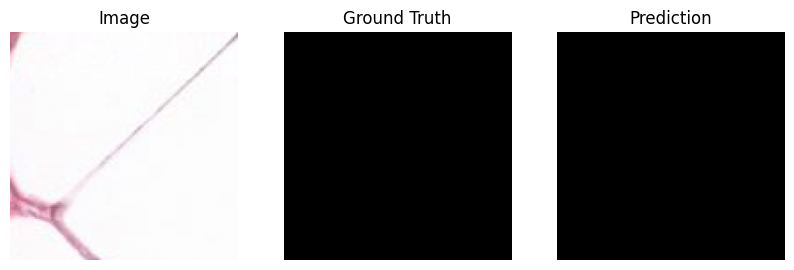

IOU (Jaccard): 0.000244140625
F1 (Dice): 0.0004881620698142797
-------------
Avg Jaccard  0.000244140625
Avg Dice  0.0004881620698142797
Avg Precision  1.0
Avg Recall  0.000244140625


In [67]:
sum_IOU = []
sum_F1 = []
sum_precison = []
sum_recall = []
threshold = -6
print(f"threshold = {threshold}")

# for batch in tqdm(test_loader):
for i in range(0, 1):
    batch = next(iter(test_loader))
    imgs, masks = batch["img"], batch["mask"]

    img = batch["img"][0].numpy(force=True)
    img = np.moveaxis(img, 0, 2)
    img_normal = imagenet_denormalise(img)
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    axs[0].imshow(img_normal)
    axs[0].title.set_text("Image")
    axs[1].imshow(masks[0][0], cmap="gray")
    axs[1].title.set_text("Ground Truth")

    imgs = imgs.to("cuda").float()
    masks = masks.to("cuda").long()
    with torch.no_grad():
        out = model(imgs)
        out = torch.nn.functional.logsigmoid(out)

    tp, fp, fn, tn = smp.metrics.get_stats(
        out, masks, mode="binary", threshold=threshold
    )
    iou_score = smp.metrics.iou_score(
        tp, fp, fn, tn, reduction="micro", zero_division=0
    )
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro", zero_division=0)
    precison_score = smp.metrics.precision(
        tp, fp, fn, tn, reduction="micro", zero_division=0
    )
    recall_score = smp.metrics.recall(
        tp, fp, fn, tn, reduction="micro", zero_division=0
    )

    iou_score = iou_score.cpu().detach().item()
    f1_score = f1_score.cpu().detach().item()
    precison_score = precison_score.cpu().detach().item()
    recall_score = recall_score.cpu().detach().item()

    if math.isnan(iou_score):
        iou_score = 1
    if math.isnan(f1_score):
        f1_score = 1
    if math.isnan(precison_score):
        precison_score = 1
    if math.isnan(recall_score):
        recall_score = 1

    out = out.cpu().detach().numpy()
    print(np.max(out))
    out_mask = out[0][0]

    out_mask[out_mask >= threshold] = 1
    out_mask[out_mask < threshold] = 0
    out_mask = erode_mask(out_mask)

    pred_centers = get_cell_centers(out_mask)

    masks = masks.cpu().detach().numpy()[0][0].astype(np.uint8)
    true_centers = get_cell_centers(masks)

    xs, ys = evaluate_cell_predictions(true_centers, pred_centers)

    axs[2].imshow(out_mask, cmap="gray")
    axs[2].title.set_text("Prediction")

    axs[0].scatter(ys, xs)
    axs[1].scatter(ys, xs)
    axs[2].scatter(ys, xs)

    for ax in fig.axes:
        ax.axis("off")
    plt.show()

    print(f"IOU (Jaccard): {iou_score}")
    print(f"F1 (Dice): {f1_score}")

    sum_IOU.append(iou_score)
    sum_F1.append(f1_score)
    sum_precison.append(precison_score)
    sum_recall.append(recall_score)

# sum_IOU = np.array(sum_IOU)
# sum_F1 = np.array(sum_F1)
print("-------------")
print("Avg Jaccard ", np.mean(sum_IOU))
print("Avg Dice ", np.mean(sum_F1))
print("Avg Precision ", np.mean(sum_precison))
print("Avg Recall ", np.mean(sum_recall))